In [2]:
import pandas as pd
import numpy as np

from sklearn import ensemble

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [3]:
#Load the RF and XGB features, which contains the list of Features to include in the linear model:
rfFeatures = pd.read_csv('rfFeatures.csv')
xgbFeatures = pd.read_csv('xgbFeatures.csv')

#Change column head
lst = [rfFeatures, xgbFeatures]
for df in lst:
    df.columns = ['Feature','Score']

In [4]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesxDF = pd.concat([AmesDummiesOrdinal[list(xgbFeatures['Feature'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)

In [5]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesxDF2 = AmesxDF.copy()
AmesxDF = AmesxDF.iloc[trainIdxes,]
AmesxDFTest = AmesxDF2.iloc[testIdxes,]

In [6]:
#Reset indices of AmesDF
AmesxDF.index = range(1166)

In [7]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [50, 100, 200, 400, 600, 800, 1000, 1200]
# Type of loss
loss = ['ls', 'lad', 'huber']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 10, 15]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
max_features = ['auto', 'sqrt', 'log2', None]
# Method of selecting samples by tree.
max_colsample = ["colsample_bytree", np.linspace(0.3, 0.5, 9),]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'loss': loss}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gradientBoost = ensemble.GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gradientBoost_random = GridSearchCV(estimator = gradientBoost, param_grid = random_grid,
                                    cv = 3, verbose=2, n_jobs = 1)
# Fit the random search model
gradientBoost_random.fit(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Then print the best parameters using best_params_
gradientBoost_random.best_params_

Fitting 3 folds for each of 9600 candidates, totalling 28800 fits
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimat

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimat

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_es

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100,

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.0s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_es

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   0.9s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimat

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   0.9s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   0.9s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_es

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimato

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.5s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=800, total=   0.8s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_es

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   2.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   1.7s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   1.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimat

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   1.8s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.7s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_es

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   2.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   2.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   1.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   1.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   1.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   1.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimat

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_est

[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimator

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimator

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   0.4s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   2.4s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   2.0s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   2.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.7s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.7s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.7s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimat

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   1.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.5s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.7s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, 

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.5s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   1.9s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.1s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   1.8s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_est

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   1.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_es

[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   3.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   3.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   3.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimato

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   3.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.8s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   2.4s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_esti

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   2.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   2.1s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   2.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimator

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   2.4s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   3.6s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   2.7s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   3.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   3.3s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   3.2s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_esti

[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   1.5s
[CV] loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=5

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_est

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_esti

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimator

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_est

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2,

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   0.8s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estima

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_es

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=5

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.1s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   0.4s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_est

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.7s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   1.4s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   3.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   3.7s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   4.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   4.1s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_es

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_e

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   3.8s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   4.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   4.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimato

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   1.1s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   1.7s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   4.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   1.8s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   2.1s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=10, n_esti

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   1.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimator

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   2.4s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   2.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   3.4s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=10

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.6s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators

[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   3.1s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   3.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   3.0s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   3.8s
[CV] loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=5, max_features=None, min_samples_leaf=8, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   2.7s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   2.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   4.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   4.1s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   4.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   5.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   6.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   4.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   3.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   2.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   3.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   5.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   5.1s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   7.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   6.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   3.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   2.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   2.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   5.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   6.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   7.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   6.3s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   2.2s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   2.2s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   4.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   3.7s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   6.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, 

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   2.2s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   3.7s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   3.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   3.7s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estima

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   2.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   3.3s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   3.2s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   4.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=50, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=50, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=50, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estima

[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=600, total=   2.6s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=600, total=   2.9s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   4.5s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   4.0s
[CV] loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_esti

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   0.9s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   0.9s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   1.5s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, 

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.5s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.3s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_sampl

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   1.5s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   1.5s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   1.0s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10,

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estima

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   1.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estima

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   0.9s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=800, total=   1.0s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_es

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   0.9s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=4, 

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   0.9s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   3.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   3.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   3.9s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   5.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   6.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   4.9s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10,

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   3.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   2.3s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   4.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   4.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   6.9s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   1.1s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estima

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   2.1s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   4.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   4.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   3.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_spli

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   8.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estima

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   4.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   4.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   3.3s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=800, total=   6.2s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estima

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   3.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   3.5s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   4.9s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   4.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   2.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   4.3s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   3.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   4.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.6s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.7s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   1.4s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   5.0s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   3.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   3.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   5.8s
[CV] loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_s

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   3.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=800, total=   7.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=800, total=   4.0s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   4.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   6.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=6

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   3.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   2.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   5.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   5.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   8.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   8.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   6.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   9.1s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   8.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   8.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   1.8s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   4.0s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   8.9s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   7.9s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   7.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=  14.8s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=4, min_samp

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   1.9s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   1.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   3.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   7.5s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   7.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=  10.2s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   9.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   3.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   2.8s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   8.2s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   9.5s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   7.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   7.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=

[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   2.6s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   2.4s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   2.7s
[CV] loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   2.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   2.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, 

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_es

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.0s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=6, min_samples_split=6

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=800, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split

[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=sqrt, min_samples_leaf=8, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   0.8s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=1, min_samp

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   1.0s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=1

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_est

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_est

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.4s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   1.6s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estim

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=800, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   3.9s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   6.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   4.1s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   8.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, 

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   2.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   2.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   8.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   4.6s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   5.2s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   6.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=1, min_samples

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   1.2s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   1.3s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   2.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   1.9s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   5.3s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   5.1s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   6.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   6.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   8.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   8.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   7.0s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   7.9s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.6s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   3.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=4, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   6.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   6.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   6.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   8.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_spli

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   1.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   2.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   2.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   7.2s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=  17.5s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   8.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=10.7min
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=6, min_samp

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   1.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   2.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   2.7s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   2.8s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   8.1s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total= 3.1min
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=  17.3s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=50, total=   0.4s
[CV] loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=ls, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=1

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_est

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   2.9s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_est

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estim

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=800, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   1.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   1.0s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   1.0s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   1.0s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   1.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=6, min_samples

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   1.7s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   1.3s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   1.5s
[CV] loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, 

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_s

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=6

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   0.8s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.0s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=10, 

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.5s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=6, min_samples_s

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=6

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   1.8s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=2, min_samp

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1000, total=   1.5s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=4, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   1.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   1.7s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=1200, total=   1.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=6, min_samples_spli

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   3.0s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   2.7s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=1200, total=   2.7s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   1.4s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   1.6s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=400, total=   0.9s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   3.3s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=2, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=1200, total=   1.8s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=600, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   2.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=10, 

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.5s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, total=   1.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estima

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   2.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_esti

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800, total=   2.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800, total=   2.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=800, total=   2.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   2.3s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=800, total=   2.6s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   4.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1000, total=   2.8s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=4

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   4.9s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=800, total=   3.8s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   3.9s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000, total=   4.7s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   1.5s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   3.1s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   3.4s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   6.2s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   4.5s
[CV] loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=auto, min_samples_leaf=8, min_sampl

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   3.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   2.8s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   2.2s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   4.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   1.0s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   1.3s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   1.8s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   1.5s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   1.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, 

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   1.0s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=800, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1000, total=   1.0s
[CV] loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=800, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=6

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1000, total=   1.3s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000, total=   0.9s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1200, total=   1.0s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   1.0s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=4, min_samp

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=1200, total=   1.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=1

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1200, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_est

[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=600, total=   0.6s
[CV] loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_spli

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   2.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=4, n_est

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   2.0s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estim

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=800, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=1

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=800, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_s

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.7s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=800, total=   1.6s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=6, min_samples_split=6

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=800, total=   2.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   2.2s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1000, total=   2.1s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split

[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   0.5s
[CV] loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=3, max_features=None, min_samples_leaf=8, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800, total=   3.6s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   4.0s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   3.8s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=   3.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   3.8s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   3.8s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, total=   3.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200, total=   4.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=1, min_samp

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400, total=   1.8s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   3.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1000, total=   3.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   4.1s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200, total=   4.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   3.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   4.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   4.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=1200, total=   4.2s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   4.0s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   4.4s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   4.9s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=1200, total=   4.5s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=600, total=   2.5s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   4.5s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   4.8s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   4.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   1.7s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   1.6s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   2.5s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=600, total=   2.6s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   5.2s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=10, 

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_esti

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_esti

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=800, total=   1.6s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=800, total=   1.5s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   1.8s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   1.9s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1200, total=   2.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samp

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   1.8s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1000, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   2.2s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   1.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   2.3s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   1.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   2.3s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1200, total=   2.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   1.9s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1200, total=   2.0s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.7s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_e

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1200, total=   2.5s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10, 

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=400, total=   0.8s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_e

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_esti

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=600, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_split=10, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=6, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_esti

[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=600, total=   1.1s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   1.3s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=800, total=   1.4s
[CV] loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   3.1s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   3.2s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=800, total=   3.1s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000, total=   3.8s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4, 

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_spli

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   3.1s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=800 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=800, total=   2.8s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   3.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, total=   3.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   1.0s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=6, n_e

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=800, total=   3.0s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   3.3s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   3.7s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1000, total=   3.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=2, min_sampl

[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=100, total=   0.5s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=200, total=   0.9s
[CV] loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=400 
[CV]  loss=lad, max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=4, n_e

In [ ]:
#The grid search optimization revealed optimal parameters. Let's set these to the gradientBoost function:
gradientBoost2 = ensemble.GradientBoostingRegressor()
gradientBoost2.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

In [9]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesxDF.drop('SalePrice', axis=1)
Y = AmesxDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesxDFTest.drop('SalePrice', axis=1)
testY = AmesxDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    gradientBoost2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = gradientBoost2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = gradientBoost2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = gradientBoost2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = gradientBoost2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [10]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.9075668721076866, 0.9324486950628464, 0.9476875471483919, 0.9061340601242542, 0.9073135462657624]
[0.9153642750097969, 0.9253707748201562, 0.9192320310619537, 0.9255753846146455, 0.9205837406767228]
[0.12284928302678036, 0.11297767438573281, 0.11339476347907987, 0.11016808916089789, 0.11916114082798697]


In [12]:
'''Of the three tests performed thus far (Linear, Random Forest, and now Gradient Boost), the gradient boost results are 
clearly the best, with a RMSLE of approximately 0.120 (0.145 for Linear, 0.135 for RF).'''

'Of the three tests performed thus far (Linear, Random Forest, and now Gradient Boost), the gradient boost results are \nclearly the best, with a RMSLE of approximately 0.125 (0.145 for Linear, 0.135 for RF).'

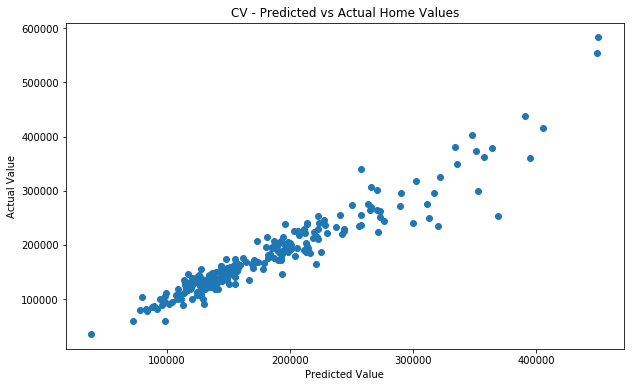

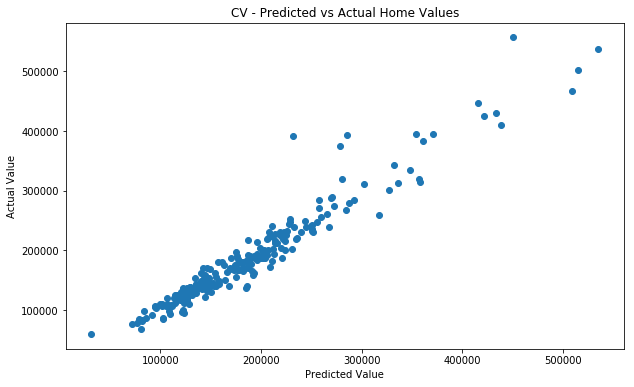

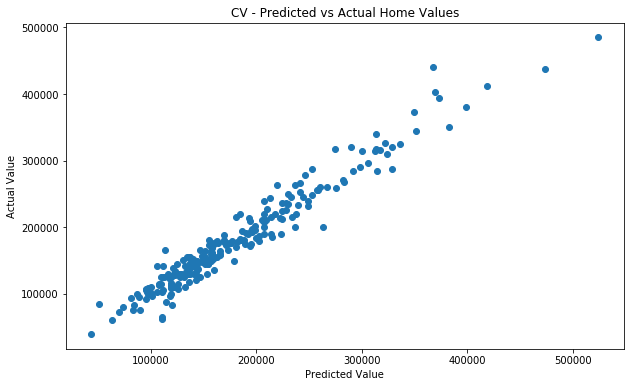

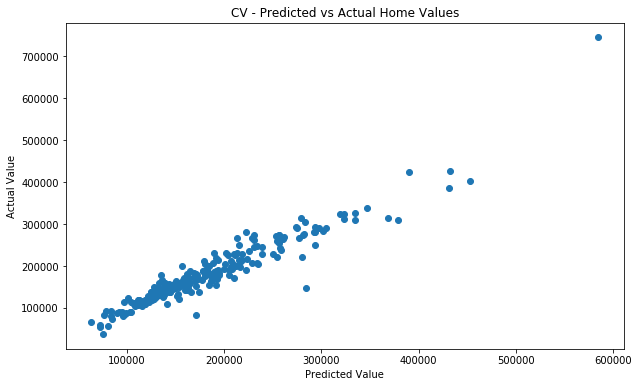

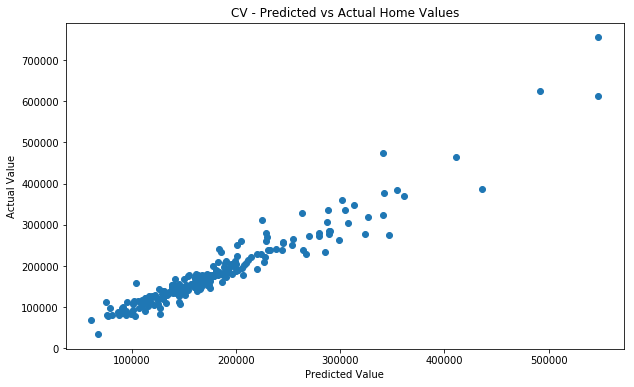

In [14]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [15]:
from xgboost import XGBRegressor

#We will perform a grid search to find the optimal hyperparameters for our RF algorithm and test using our K-fold data:

# Number of trees in random forest
n_estimators = [50, 100, 200, 400, 600, 800, 1000, 1200]
# Type of loss
loss = ['ls', 'lad', 'huber']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 10, 15]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
max_features = ['auto', 'sqrt', 'log2', None]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'loss': loss}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
xgb_random.fit(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Then print the best parameters using best_params_
xgb_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   5.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   5.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   5.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   5.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, loss=ls, total=   5.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=None, max_depth=15, loss=huber 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=None, max_dep

[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   2.2s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   2.2s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features=log2, max_depth=2, loss=lad, total=   2.2s
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls, total=   1.4s
[CV] n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3, loss=ls 
[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=3

[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad, total=   0.3s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=5, loss=lad, total=   0.4s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber, total=   5.3s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber, total=   4.5s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=log2, m

[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features=log2, max_depth=2, loss=huber, total=   2.6s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   1.0s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   0.9s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber, total=   1.3s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=10, loss=huber 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   8.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   9.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   9.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls, total=   8.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, loss=ls 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto,

[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   2.4s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   2.7s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   2.7s
[CV] n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls 
[CV]  n_estimators=600, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=3, loss=ls, total=   2.6s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, los

[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   3.4s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   3.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=2, loss=ls, total=   3.3s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls, total=   0.7s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, loss=ls 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad, total=  10.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, loss=lad, total=  11.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad, total=   0.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad, total=   0.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=aut

[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=2, loss=huber, total=   1.4s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  13.2s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  12.5s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad, total=  12.7s
[CV] n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto, max_depth=15, loss=lad 
[CV]  n_estimators=800, min_samples_split=6, min_samples_leaf=8, max_features=auto,

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls, total=   0.7s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=15, loss=ls 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=None, max_dept

[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=5, loss=huber, total=   0.3s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max

[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   0.7s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   0.7s
[CV] n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad 
[CV]  n_estimators=50, min_samples_split=6, min_samples_leaf=8, max_features=None, max_depth=15, loss=lad, total=   0.7s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber, total=  11.5s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=15, loss=huber 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=1, max_features=sqrt,

[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls, total=   8.8s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=15, loss=ls, total=   9.0s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad, total=   2.2s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad, total=   2.2s
[CV] n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_depth=5, loss=lad 
[CV]  n_estimators=400, min_samples_split=6, min_samples_leaf=6, max_features=sqrt, max_d

[CV]  n_estimators=1200, min_samples_split=4, min_samples_leaf=8, max_features=sqrt, max_depth=15, loss=huber, total=  42.1s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   2.4s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   1.6s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls, total=   1.8s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=10, loss=ls 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 40.9min finished


{'n_estimators': 800,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 2,
 'loss': 'lad'}

In [20]:
import xgboost

In [11]:
#The grid search optimization revealed optimal parameters. Let's set these to the gradientBoost function:
xgb2 = XGBRegressor()
xgb2.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=2, max_features='log2', 
                max_depth=2, loss='lad')


NameError: name 'XGBRegressor' is not defined

In [23]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesxDF.drop('SalePrice', axis=1)
Y = AmesxDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesxDFTest.drop('SalePrice', axis=1)
testY = AmesxDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesxDF.drop('SalePrice', axis=1), AmesxDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []

for train, test in AmesDF5Fold:
    #Run the fit using the train data for each K
    xgb2.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = xgb2.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = xgb2.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = xgb2.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = xgb2.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)

In [26]:
#What are the R^2 values for our runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.9042149695716408, 0.9256502374429275, 0.9184573319729729, 0.9107073038618928, 0.9198086736387849]
[0.9129565240440349, 0.9192795273209675, 0.9158824745060954, 0.91417413750223, 0.9140443304356997]
[0.12352586010672806, 0.1165149193581772, 0.11707462491460013, 0.12227196000878605, 0.12211850663196386]


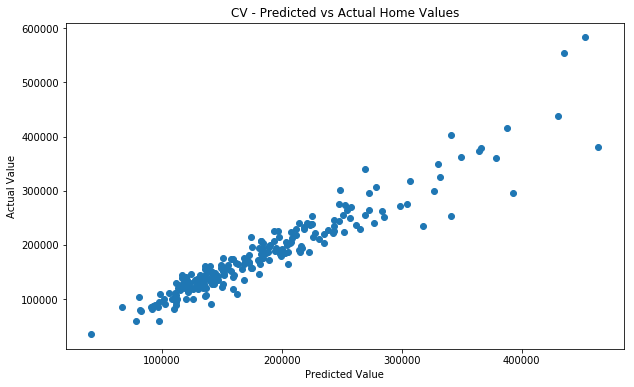

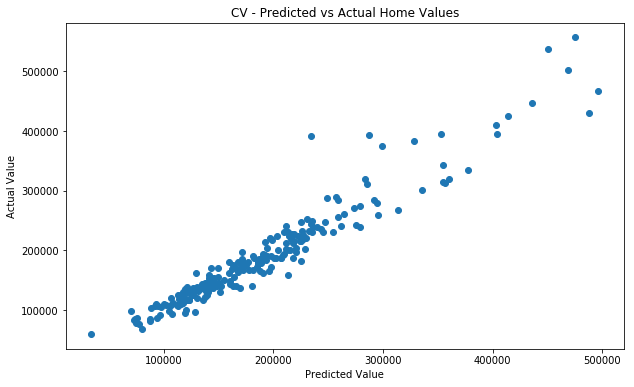

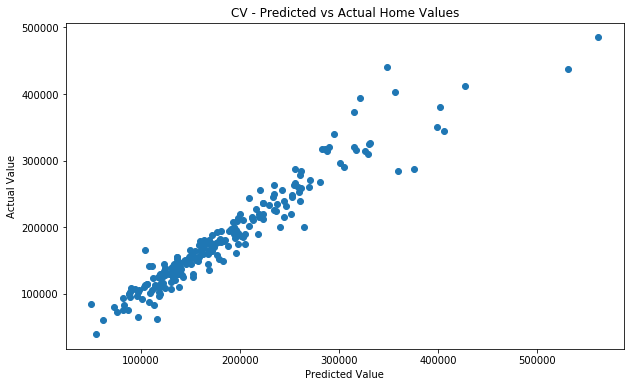

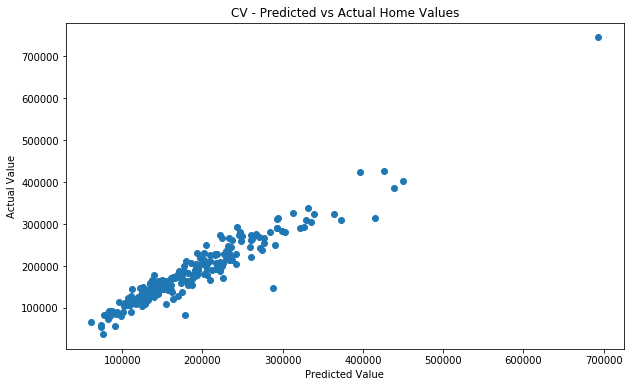

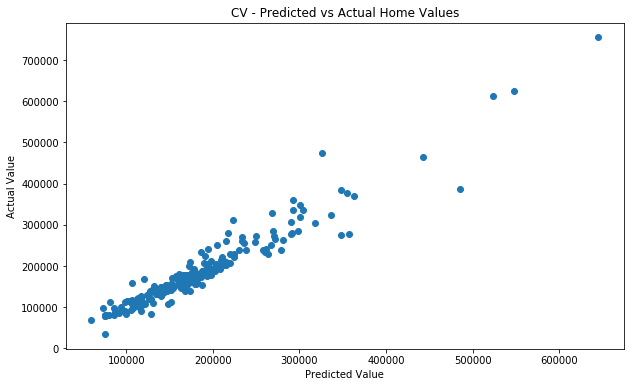

In [27]:
for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [ ]:
### Adaboost